# Multi-layer perceptron emulator
### Initial notebook by Nicole Hartman (nhartman94)
#### Modifications by Cole Johnston

We are trying to develop an emulator that takes in a vector or parameters ($\theta$) and outputs a phase-folded time series eclipsing binary model ($\bf{Y}$) and accompanying physical parameters ($\psi$).

In [1]:
## Standard imports
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

In [2]:
## Load up the training data
ddir = './data/training/'

X = pd.read_csv(f'{ddir}/theta.txt')[8000:] # ,index=False 
psi   = pd.read_csv(f'{ddir}/psi.txt')[8000:]

psi['radius1'] = np.log(psi['radius1'] )
psi['radius2'] = np.log(psi['radius2'] )

Y   = pd.read_csv(f'{ddir}/simulations.txt')[8000:]

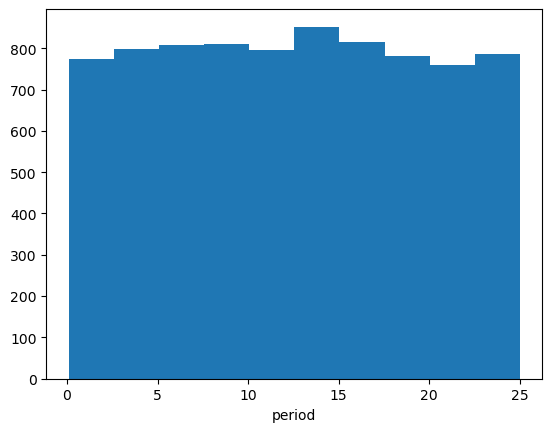

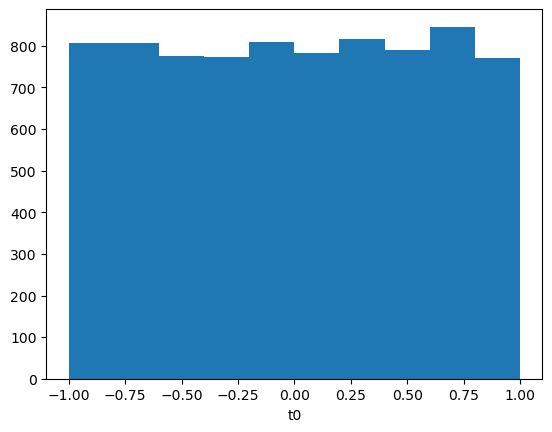

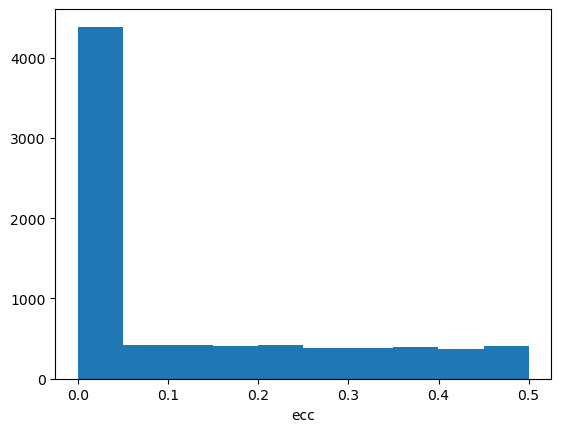

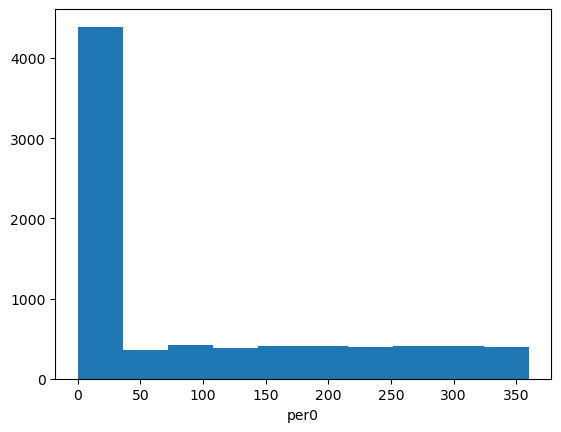

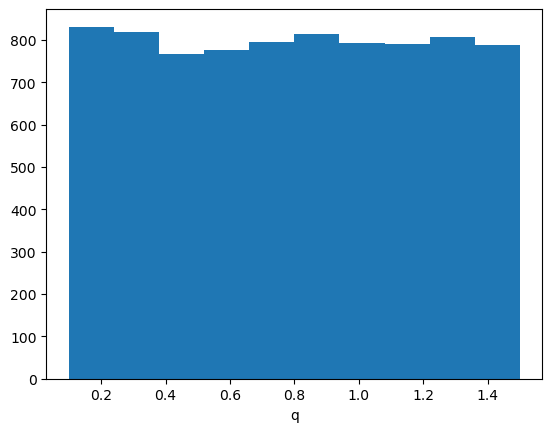

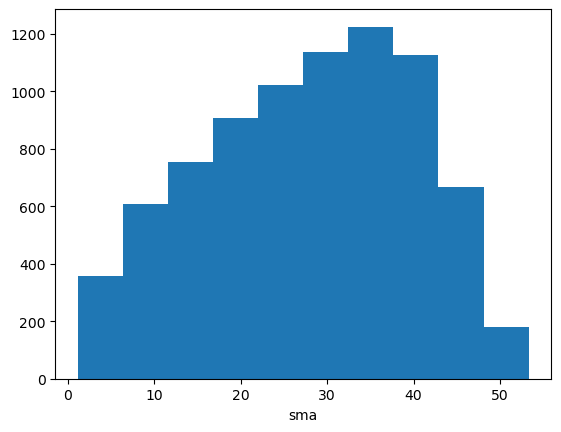

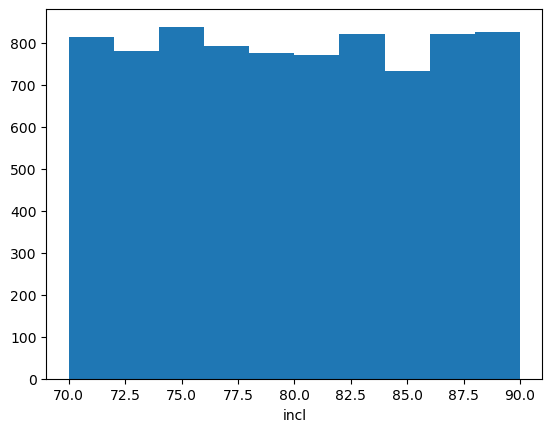

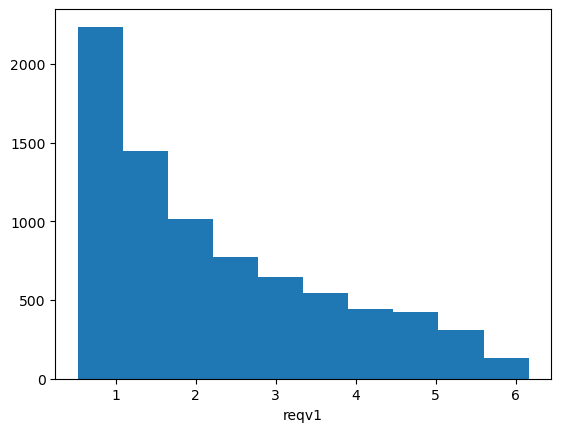

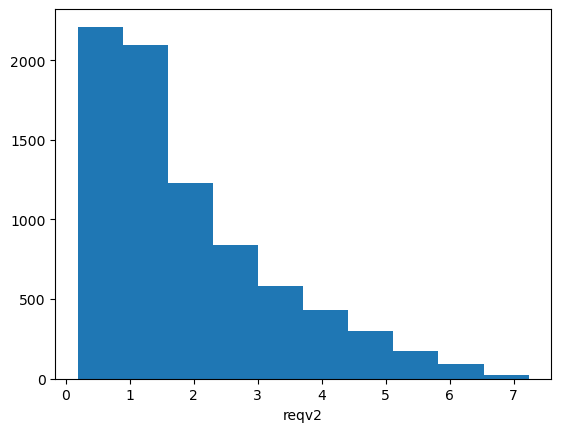

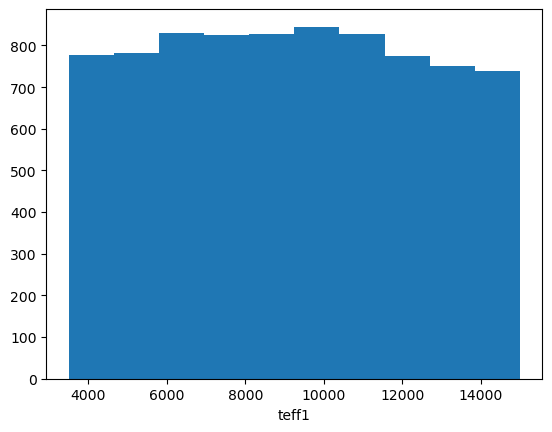

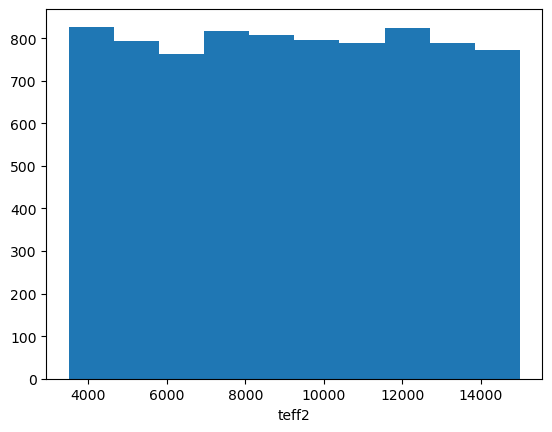

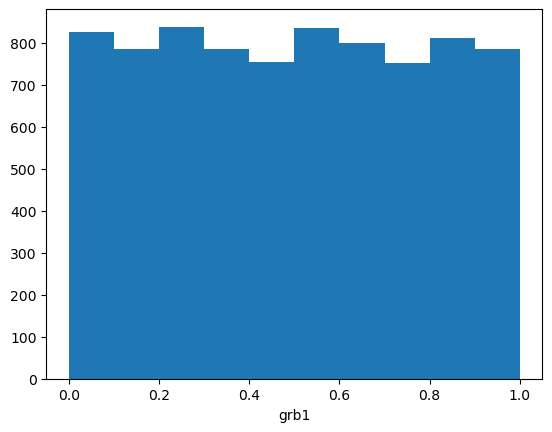

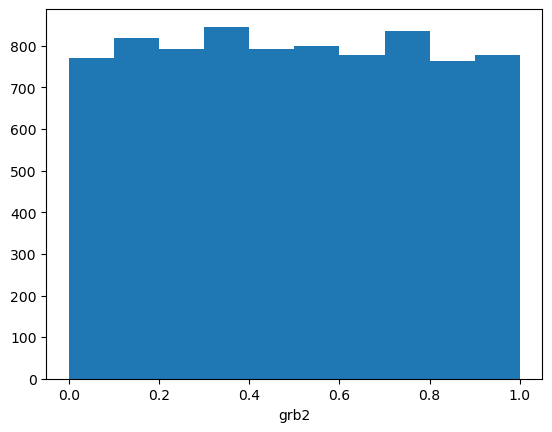

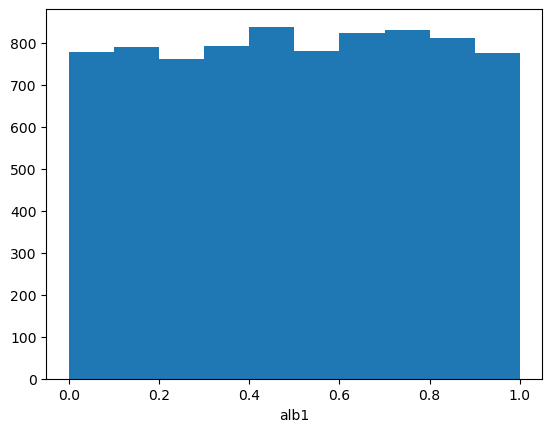

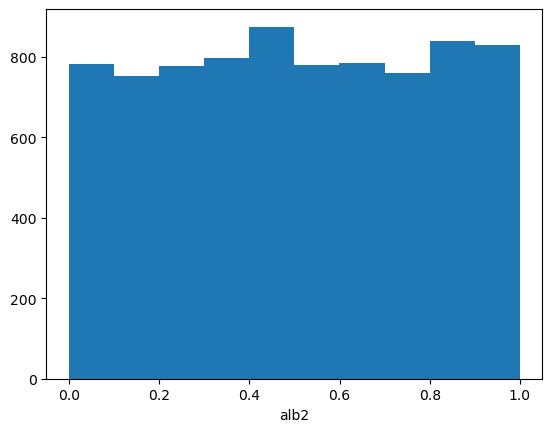

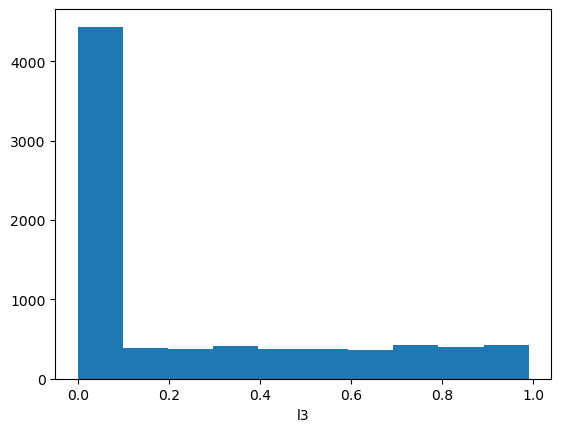

In [3]:
for c in X.columns[1:]:
    # plt.figr
    plt.hist(X[c])
    plt.xlabel(c)
    plt.show()

- ecc: log norm
- per0 : log norm
- reqv{1,2}
- l3

In [4]:
X.columns[1:]

Index(['period', 't0', 'ecc', 'per0', 'q', 'sma', 'incl', 'reqv1', 'reqv2',
       'teff1', 'teff2', 'grb1', 'grb2', 'alb1', 'alb2', 'l3'],
      dtype='object')

In [4]:
# Original log cols
# log_cols = ['ecc', 'per0','reqv1', 'reqv2','l3']

# New log cols
log_X_cols = ['period', 'per0', 'sma', 'incl', 'reqv1', 'reqv2', 'teff1', 'teff2', 'ecc', 'l3','q']

In [5]:
eps = 1e-10
# train_X = pd.DataFrame(np.column_stack([np.log(X[c]+eps) if c in log_X_cols else X[c] for c in X.columns[1:]]),
#                        columns=X.columns[1:])
train_X = pd.DataFrame(np.column_stack([X[c]+eps if c in log_X_cols else X[c] for c in X.columns[1:]]),
                       columns=X.columns[1:])


In [6]:
train_X

,period,t0,ecc,per0,q,sma,incl,reqv1,reqv2,teff1,teff2,grb1,grb2,alb1,alb2,l3
0,12.01081,0.07934,1.011300e-01,1.215461e+02,1.13589,31.68487,76.40885,0.78075,2.63553,8610.07309,12978.81272,0.88133,0.20348,0.94891,0.66040,0.40194
1,11.16576,0.79878,3.850000e-02,3.468140e+02,1.32844,30.62991,70.90244,2.15604,2.72837,10184.14749,13358.77510,0.99362,0.11237,0.28126,0.71660,0.12556
2,13.47622,0.79776,6.574000e-02,1.901459e+02,1.15294,32.52684,74.02857,3.19611,3.34196,12527.40171,4857.86049,0.94321,0.19113,0.03809,0.97552,0.73874
3,13.88738,-0.28990,1.223600e-01,1.826137e+02,0.26732,27.09031,77.52717,1.11371,0.55675,5769.58783,10055.80213,0.80444,0.88463,0.93651,0.17788,0.80873
4,19.19531,0.71636,3.337800e-01,1.138521e+02,0.52170,37.28620,76.86220,3.72505,0.52531,8450.90582,7775.96518,0.09896,0.65885,0.28939,0.33337,0.26629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973,12.70677,0.89070,1.000000e-10,1.000000e-10,0.69047,29.52038,72.67878,2.00565,0.82267,9370.26146,4462.81151,0.74061,0.23291,0.46849,0.78082,0.40903
7974,7.91845,-0.12254,1.000000e-10,1.000000e-10,0.82892,20.45778,83.19220,1.02487,1.30095,8602.75496,7084.02536,0.50276,0.17757,0.70673,0.06298,0.58409
7975,10.73896,-0.91073,1.000000e-10,1.000000e-10,1.36684,27.84397,74.07450,0.73637,0.71663,5680.39582,12445.65064,0.79344,0.65892,0.18540,0.69173,0.34211
7976,0.51455,0.38839,1.000000e-10,1.000000e-10,1.19176,3.83150,79.28031,4.59410,5.61622,12791.76588,14466.60772,0.82569,0.27321,0.21544,0.71696,0.50020


In [7]:
train_X_ = train_X.values
train_X_norm = (train_X_ - train_X_.mean(axis=0))/ train_X_.std(axis=0)

In [47]:
train_X_norm

array([[-0.07229045,  0.13428606, -0.14106998, ...,  1.54937881,
         0.53770261,  0.47806892],
       [-0.19097609,  1.38119205, -0.5316143 , ..., -0.77150474,
         0.73219903, -0.37930025],
       [ 0.13352355,  1.37942423, -0.36175278, ..., -1.61681179,
         1.62826688,  1.52286933],
       ...,
       [-0.25091933, -1.58166553, -0.77169025, ..., -1.10473308,
         0.64612917,  0.29246795],
       [-1.68691796,  0.66991974, -0.77169025, ..., -1.00030809,
         0.73344492,  0.7828851 ],
       [ 0.99906286,  0.26137882, -0.77169025, ..., -0.26641318,
        -0.90970376,  1.05503575]])

In [8]:
# ? StandardScaler.fit_transform

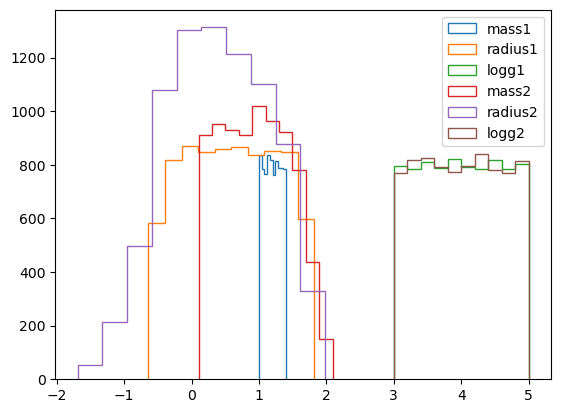

In [9]:
for c in psi.columns[1:]:
    plt.hist(psi[c],histtype='step',label=c)
plt.legend()


In [16]:
y1 = psi[psi.columns[1:]].values
# y1 = (y1 - y1.mean(axis=0))/ y1.std(axis=0)

y2 = Y[Y.columns[1:]].values
y2 -= 1

In [48]:
Y

,simulation,0000,0001,0002,0003,0004,0005,0006,0007,0008,...,0490,0491,0492,0493,0494,0495,0496,0497,0498,0499
8000,8000,0.99952,0.99952,0.99952,0.99952,0.99952,0.99952,0.99952,0.99952,0.99952,...,0.99955,0.99955,0.99954,0.99954,0.99954,0.99953,0.99953,0.99953,0.99952,0.99952
8001,8001,0.99956,0.99956,0.99956,0.99957,0.99957,0.99957,0.99957,0.99958,0.99958,...,0.99956,0.99956,0.99956,0.99956,0.99956,0.99956,0.99956,0.99956,0.99956,0.99956
8002,8002,0.99903,0.99903,0.99903,0.99902,0.99902,0.99902,0.99901,0.99901,0.99901,...,0.99911,0.99910,0.99909,0.99908,0.99907,0.99906,0.99906,0.99905,0.99904,0.99904
8003,8003,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,...,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
8004,8004,0.99835,0.99834,0.99834,0.99834,0.99834,0.99834,0.99835,0.99836,0.99838,...,0.99863,0.99859,0.99856,0.99852,0.99849,0.99846,0.99843,0.99840,0.99838,0.99837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15973,15973,0.99978,0.99978,0.99978,0.99979,0.99979,0.99979,0.99979,0.99979,0.99979,...,0.99979,0.99979,0.99979,0.99979,0.99979,0.99979,0.99979,0.99979,0.99978,0.99978
15974,15974,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,...,0.99987,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986,0.99986
15975,15975,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,...,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999
15976,15976,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [17]:
H = 
d_in = 16
d_out = 506

'''
To improve:
- Dropout
- Batch norm
- Layer norm
'''

# m = nn.Sequential(nn.Linear(d_in,H), 
#               nn.ReLU(), 
#               nn.Linear(H,H),
#               nn.ReLU(), 
#               nn.Linear(H,H),
#               nn.Linear(H,d_out))

'\nTo improve:\n- Dropout\n- Batch norm\n- Layer norm\n'

In [18]:
'''
Is valid, zeros or nans
'''

'\nIs valid, zeros or nans\n'

In [19]:
def get_data(N, X, y1, y2):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    i_batch = idx[:N]
    xi = torch.FloatTensor(X[i_batch])
    yi_1 = torch.FloatTensor(y1[i_batch])
    yi_2 = torch.FloatTensor(y2[i_batch])

    return xi,yi_1, yi_2

def get_data_no_psi(N, X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    i_batch = idx[:N]
    xi = torch.FloatTensor(X[i_batch])
    yi = torch.FloatTensor(y[i_batch])

    return xi, yi

**To come back:**
- Check if sigmoiding output for simulations (timeseries) helps

In [35]:
d_psi = 6
def train_model_with_psi(model):

    losses = []
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    for i in range(5000): # 5k training steps
        xi, yi_1, yi_2 = get_data(100, train_X_norm, y1, y2) # Draw 5000 samples
        y_pred = model(xi)
        y1_pred = y_pred[:, :d_psi]
        y2_pred = y_pred[:, d_psi:]
        loss_1 = nn.MSELoss()(y1_pred,yi_1)
        loss_2 = nn.MSELoss()(y2_pred,yi_2) # maybe BCE if we sigmoid output

        loss = loss_1 + loss_2
        loss = loss_2
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(float(loss))
        if i % 500 == 0:
            print(float(loss))
    return model,losses




In [26]:
m_with_psi = nn.Sequential(nn.Linear(d_in,H), 
                           nn.ReLU(), 
                           nn.Linear(H,H),
                           nn.ReLU(), 
                           nn.Linear(H,H),
                           nn.ReLU(), 
                           nn.Linear(H,H),
                           nn.Linear(H,d_out)
                          )

trained_model_with_psi, losses_with_psi = train_model_with_psi(m_with_psi)

0.13560092449188232
0.013531242497265339
0.007003305479884148
0.005174766294658184
0.001877615344710648
0.0016901724739000201
0.0012315261410549283
0.0004430415283422917
0.000542398658581078
0.000548860989511013


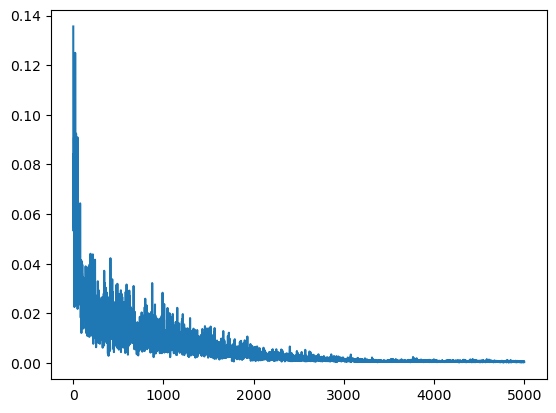

In [27]:
plt.plot(losses_with_psi)

tensor([ 0.1170,  0.0915, -0.1068,  0.0670, -0.0588,  0.0976],
       grad_fn=<SliceBackward0>)
[1.30707    0.28382464 4.30784    1.94841    0.463344   4.32529   ]


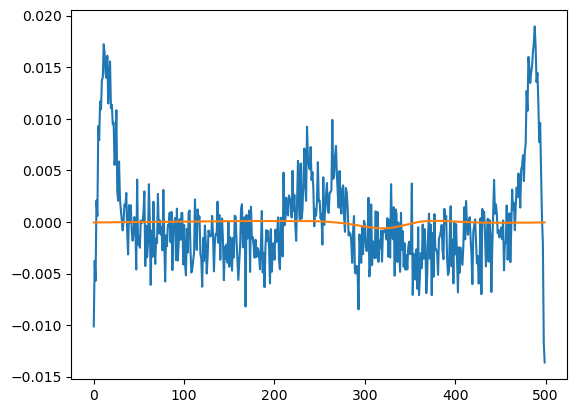

In [29]:
test_idx = 1000
yy = trained_model_with_psi(torch.FloatTensor(train_X_norm[test_idx]))
yy_psi = yy[:d_psi]
yy_lc = yy[d_psi:]
plt.plot(yy_lc.detach().numpy())
plt.plot(y2[test_idx])
print(yy_psi)
print(y1[test_idx])

In [60]:
def train_model_no_psi(model):
    
    losses = []
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    for i in range(10000): # 5k training steps
        xi, yi = get_data_no_psi(100, train_X_norm, y2) # Draw 5000 samples
        y_pred = model(xi)
        loss   = nn.MSELoss()(y_pred,yi) # maybe BCE if we sigmoid output
        # loss   = nn.L1Loss()(y_pred, yi)
        opt.zero_grad()
        loss.backward()
        opt.step()
        

        losses.append(float(loss))
        if i % 500 == 0:
            print(float(loss))
    return model,losses

m_no_psi = nn.Sequential(nn.Linear(16,H), 
                           nn.ReLU(), 
                           nn.Linear(H,H),
                           nn.ReLU(), 
                           nn.Linear(H,H),
                           nn.ReLU(), 
                           nn.Linear(H,H),
                         nn.Linear(H,500),
                        )



In [61]:
trained_model_no_psi, losses_no_psi = train_model_no_psi(m_no_psi)

0.08639029413461685
0.017547566443681717
0.00599680794402957
0.01018557883799076
0.0025042942725121975
0.0018869501072913408
0.0010506915859878063
0.0008539761183783412
0.0011266235960647464
0.0004995644558221102
0.0008830027654767036
0.0005208314396440983
0.0005748090916313231
0.0005756209138780832
0.0010025911033153534
0.0004201139381621033
0.0005165222100913525
0.0003398810513317585
0.00033639834146015346
0.001980406465008855


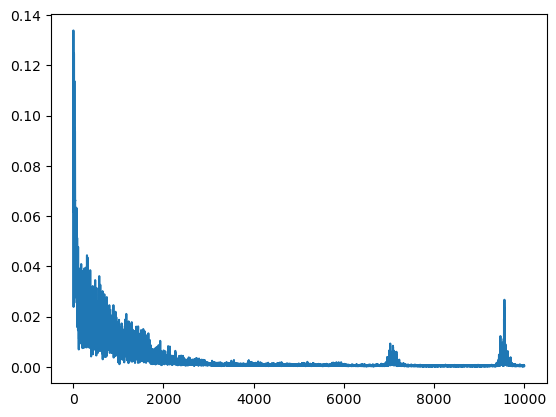

In [62]:
plt.plot(losses_no_psi)

[-1.6021421   0.09461399  0.88807637  1.95843383 -0.78931253 -1.85921471
  1.46821228 -1.07984511 -0.56619817  0.26119803 -0.16181587 -0.80893809
 -1.25802406 -1.63624374 -0.93455223  1.28567978]


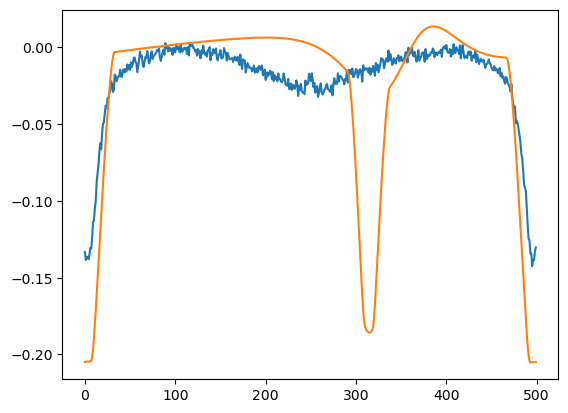

In [63]:
m_no_psi.eval()
with torch.no_grad():
    test_idx = 1002
    yy = trained_model_no_psi(torch.FloatTensor(train_X_norm[test_idx]))
    print(train_X_norm[test_idx])
    plt.plot(yy.detach().numpy())
    plt.plot(y2[test_idx])
